In [34]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt

In [35]:
# Set random seed
key = jax.random.PRNGKey(0)

# Parameters
omega = 15.0
num_collocation = 100

In [36]:
# Collocation points
x_collocation = np.linspace(0, 2 * np.pi, num_collocation).reshape(-1, 1)
x_collocation = jnp.array(x_collocation)

In [37]:
# Neural network model using Flax
class MLP(nn.Module):
    hidden_dim: int = 32

    @nn.compact
    def __call__(self, x):
        x = nn.tanh(nn.Dense(self.hidden_dim)(x))
        x = nn.tanh(nn.Dense(self.hidden_dim)(x))
        x = nn.Dense(1)(x)
        return x

In [38]:
# PINN ansatz: û(x) = tanh(ωx) * NN(x)
def u_hat(params, x):
    nn_out = model.apply({'params': params}, x)
    return jnp.tanh(omega * x) * nn_out

# Compute dû/dx
def du_hat_dx(params, x):
    return jax.grad(lambda x_: u_hat(params, x_).squeeze())(x)

# Residual of the ODE
def residual(params, x):
    return du_hat_dx(params, x) - jnp.cos(omega * x.squeeze())

# Loss function
def loss_fn(params, x):
    res = jax.vmap(lambda xi: residual(params, xi))(x)
    return jnp.mean(res ** 2)

In [39]:
# Training step
@jax.jit
def train_step(state, x):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, x)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [40]:
# Initialize model and optimizer
model = MLP()
params = model.init(key, x_collocation)['params']
tx = optax.adam(learning_rate=0.01)

state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [41]:
# Training loop
epochs = 5000
loss_pred = []
for epoch in range(epochs):
    state, loss = train_step(state, x_collocation)
    loss_pred.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss}")

Epoch 0: Loss = 0.5076871514320374
Epoch 500: Loss = 0.4012201726436615
Epoch 1000: Loss = 0.2733626067638397
Epoch 1500: Loss = 0.2456902712583542
Epoch 2000: Loss = 0.2147962898015976
Epoch 2500: Loss = 0.18365827202796936
Epoch 3000: Loss = 0.17111951112747192
Epoch 3500: Loss = 0.1526087373495102
Epoch 4000: Loss = 0.13274642825126648
Epoch 4500: Loss = 0.1076587587594986


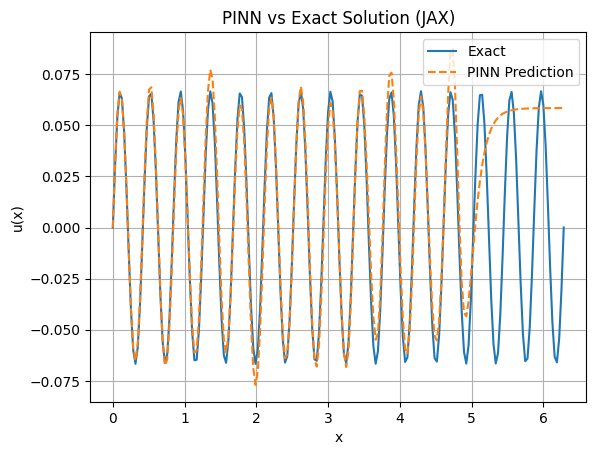

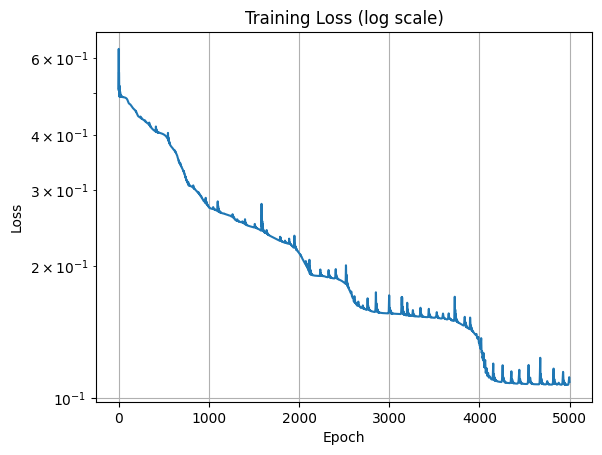

In [42]:
# Prediction
x_plot = jnp.linspace(0, 2 * jnp.pi, 200).reshape(-1, 1)
u_pred = u_hat(state.params, x_plot)
u_exact = (1 / omega) * jnp.sin(omega * x_plot)

# Plotting
plt.plot(x_plot, u_exact, label='Exact')
plt.plot(x_plot, u_pred, '--', label='PINN Prediction')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("PINN vs Exact Solution (JAX)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(loss_pred)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (log scale)")
plt.grid(True)
plt.show()